In [17]:
import re
from collections import Counter, defaultdict
from typing import Dict, List, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numba import njit
from sklearn.manifold import MDS
from sklearn.utils import check_random_state

In [18]:
@njit
def calculate_pair_mentions(ballots: np.ndarray, num_candidates: int, num_ballots: int, num_ranks: int) -> np.ndarray:
    """
    Calculate the number of times each pair of candidates is mentioned together in the ballots.

    Parameters
    ----------
    ballots : numpy.ndarray
        An array representing the ranked votes. Each row is a ballot, with candidates represented by their indices.
    num_candidates : int
        The total number of unique candidates.
    num_ballots : int
        The total number of ballots.
    num_ranks : int
        The total number of ranks in each ballot.

    Returns
    -------
    numpy.ndarray
        A square matrix where the entry at row i and column j represents the number of times candidate i and candidate j are mentioned together in the ballots.
    """
    
    # Initialize a zero matrix to store the counts of pair mentions
    pair_mentions = np.zeros((num_candidates, num_candidates))
    
    # For each ballot
    for i in range(num_ballots):
        # For each rank in the ballot
        for j in range(num_ranks):
            # For each other rank in the ballot
            for k in range(num_ranks):
                # If either of the candidates in the rank is invalid 
                if np.isnan(ballots[i, j]) or np.isnan(ballots[i, k]):
                    continue
                # Else increment the count for the rank pair
                pair_mentions[int(ballots[i, j]) - 1, int(ballots[i, k]) - 1] += 1

    return pair_mentions

In [19]:
# Default values to ignore when reading CSV
ignore_values = ['UWI', '(WRITE-IN)', 'WRITE-IN', 'writein', 'Write-In', 'Write-in', 'skipped', 'overvote', 'Undeclared', 'undervote']

# Load the CSV file and filter to keep only the 'rank' columns
df = pd.read_csv("../rcv_elections_database/proportional/Minneapolis 2013-board of estimation and taxation cvr.csv")
df = df.filter(regex='^rank')

# Replace non-candidate values with None
for ignore_value in ignore_values:
    df.replace(to_replace=re.compile(ignore_value), value=None, regex=True, inplace=True)

# Create a list of all candidate names and convert names to integer codes
raw_ballots = df.values.tolist()
candidate_names = [name for name in pd.unique(df.values.ravel()) if pd.notna(name)]
candidate_dict = {name: i for i, name in enumerate(candidate_names)}
num_candidates = len(candidate_names)

# Reverse mapping from integer codes to candidate names
reverse_candidate_dict = {v: k for k, v in candidate_dict.items()}

# Convert ballots to integers representing candidates, replacing invalid candidates with NaN
ballots = [[candidate_dict.get(candidate, np.nan) for candidate in ballot] for ballot in raw_ballots]
ballots = np.array(ballots)

# Create a DataFrame for displaying the ballots
ballots_df = pd.DataFrame(ballots, columns=df.columns)
ballots_df = ballots_df.replace(reverse_candidate_dict)
ballots_df

,rank1,rank2,rank3
0,CAROL J. BECKER,CAROL J. BECKER,CAROL J. BECKER
1,CAROL J. BECKER,CAROL J. BECKER,CAROL J. BECKER
2,CAROL J. BECKER,CAROL J. BECKER,CAROL J. BECKER
3,CAROL J. BECKER,CAROL J. BECKER,CAROL J. BECKER
4,CAROL J. BECKER,CAROL J. BECKER,CAROL J. BECKER
...,...,...,...
80096,NaN,NaN,NaN
80097,NaN,NaN,NaN
80098,NaN,NaN,NaN
80099,NaN,NaN,NaN


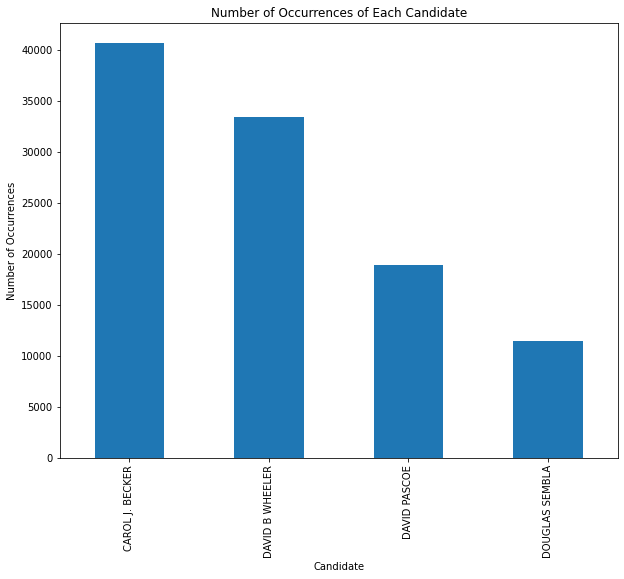

In [20]:
# Count the number of occurrences of each candidate
candidate_counts = ballots_df.stack().value_counts()

# Plot the results
plt.figure(figsize=(10, 8))
candidate_counts.plot(kind='bar')
plt.title('Number of Occurrences of Each Candidate')
plt.xlabel('Candidate')
plt.ylabel('Number of Occurrences')
plt.show()

In [21]:
# Default values to ignore when reading CSV
ignore_values = ['UWI', '(WRITE-IN)', 'WRITE-IN', 'writein', 'Write-In', 'Write-in', 'skipped', 'overvote', 'Undeclared', 'undervote']

# Load the CSV file and filter to keep only the 'rank' columns
df = pd.read_csv("../rcv_elections_database/proportional/Minneapolis_11072017_ParkBoardAtLarge.csv")
df = df.filter(regex='^rank')

# Replace non-candidate values with None
for ignore_value in ignore_values:
    df.replace(to_replace=re.compile(ignore_value), value=None, regex=True, inplace=True)

# Create a list of all candidate names and convert names to integer codes
raw_ballots = df.values.tolist()
candidate_names = [name for name in pd.unique(df.values.ravel()) if pd.notna(name)]
candidate_dict = {name: i for i, name in enumerate(candidate_names)}
num_candidates = len(candidate_names)

# Reverse mapping from integer codes to candidate names
reverse_candidate_dict = {v: k for k, v in candidate_dict.items()}

# Convert ballots to integers representing candidates, replacing invalid candidates with NaN
ballots = [[candidate_dict.get(candidate, np.nan) for candidate in ballot] for ballot in raw_ballots]
ballots = np.array(ballots)

# Create a DataFrame for displaying the ballots
ballots_df = pd.DataFrame(ballots, columns=df.columns)
ballots_df = ballots_df.replace(reverse_candidate_dict)
ballots_df

,rank1,rank2,rank3
0,Meg Forney,Latrisha Vetaw,Devin Hogan
1,Meg Forney,Mike Derus,Latrisha Vetaw
2,NaN,NaN,NaN
3,Russ Henry,Devin Hogan,Londel French
4,Meg Forney,NaN,NaN
...,...,...,...
105923,Latrisha Vetaw,Meg Forney,Mike Derus
105924,Mike Derus,Latrisha Vetaw,NaN
105925,Londel French,NaN,NaN
105926,Devin Hogan,Charlie Casserly,Jonathan Honerbrink


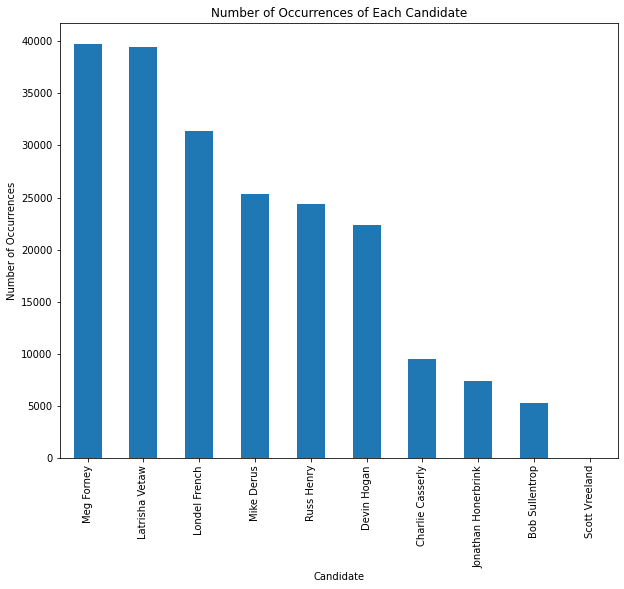

In [22]:
# Count the number of occurrences of each candidate
candidate_counts = ballots_df.stack().value_counts()

# Plot the results
plt.figure(figsize=(10, 8))
candidate_counts.plot(kind='bar')
plt.title('Number of Occurrences of Each Candidate')
plt.xlabel('Candidate')
plt.ylabel('Number of Occurrences')
plt.show()

In [23]:
# Count up frequencies of consecutive-pair ballot choices
num_ballots, num_ranks = ballots.shape
counts = np.zeros((num_candidates, num_candidates))
for i in range(num_ballots):
    for j in range(num_ranks - 1):
        if np.isnan(ballots[i, j]) or np.isnan(ballots[i, j+1]):
            continue
        counts[int(ballots[i, j]), int(ballots[i, j+1])] += 1

# Create a DataFrame for displaying the counts
counts_df = pd.DataFrame(counts, index=candidate_names, columns=candidate_names)
counts_df

,Meg Forney,Latrisha Vetaw,Devin Hogan,Mike Derus,Russ Henry,Londel French,Jonathan Honerbrink,Charlie Casserly,Bob Sullentrop,Scott Vreeland
Meg Forney,410.0,6838.0,1925.0,5299.0,1973.0,3419.0,981.0,1649.0,673.0,0.0
Latrisha Vetaw,7772.0,445.0,3217.0,3387.0,3072.0,6396.0,640.0,725.0,313.0,2.0
Devin Hogan,1267.0,2476.0,179.0,804.0,3092.0,3242.0,422.0,363.0,396.0,1.0
Mike Derus,4585.0,3108.0,1088.0,321.0,1357.0,1172.0,839.0,1358.0,563.0,1.0
Russ Henry,1870.0,2693.0,3580.0,1359.0,198.0,3602.0,391.0,451.0,301.0,1.0
Londel French,2679.0,4221.0,5198.0,1231.0,4406.0,275.0,416.0,332.0,222.0,0.0
Jonathan Honerbrink,664.0,446.0,294.0,645.0,462.0,255.0,116.0,344.0,602.0,0.0
Charlie Casserly,1074.0,461.0,464.0,1084.0,456.0,434.0,422.0,134.0,413.0,0.0
Bob Sullentrop,383.0,223.0,192.0,461.0,340.0,132.0,553.0,361.0,90.0,0.0
Scott Vreeland,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0


In [24]:
I_1 = ["A", "B", "C", "D"] # AB, AC, AD, BC, BD, CD
I_2 = ["B", "A", "C", "D"] # BA, BC, BD, AC, AD, CD
I_3 = ["B", "C", "A", "D"] # BC, BA, BD, CA, CD, AD
I_4 = ["C", "B", "A", "D"] # CB, CA, CD, BA, BD, AD
I_5 = ["C", "B", "D", "A"] # CB, CD, CA, BD, BA, DA
I_6 = ["C", "D", "B", "A"] # CD, CB, CA, DB, DA, BA
I_7 = ["D", "C", "B", "A"] # DC, DB, DA, CB, CA, BA


# Create a list of all candidate names and convert names to integer codes
raw_ballots = np.array([I_1, I_2, I_3, I_4, I_5, I_6, I_7])
candidate_names = [name for name in raw_ballots.ravel() if pd.notna(name)]
candidate_dict = {name: i for i, name in enumerate(np.unique(candidate_names))}
num_candidates = len(candidate_dict)

# Convert ballots to integers representing candidates, replacing invalid candidates with NaN
ballots = [[candidate_dict.get(candidate, np.nan) for candidate in ballot] for ballot in raw_ballots]
ballots = np.array(ballots)

# Reverse mapping from integer codes to candidate names
reverse_candidate_dict = {v: k for k, v in candidate_dict.items()}
print(reverse_candidate_dict)

# Create a DataFrame for displaying the ballots
ballots_df = pd.DataFrame(ballots, columns=["Rank 1", "Rank 2", "Rank 3", "Rank 4"])
ballots_df.index.name = "Ballot"
ballots_df

{0: 'A', 1: 'B', 2: 'C', 3: 'D'}


,Rank 1,Rank 2,Rank 3,Rank 4
Ballot,,,,
0,0,1,2,3
1,1,0,2,3
2,1,2,0,3
3,2,1,0,3
4,2,1,3,0
5,2,3,1,0
6,3,2,1,0


In [25]:
# Count up frequencies of consecutive-pair ballot choices
num_ballots, num_ranks = ballots.shape
counts = np.zeros((num_candidates, num_candidates))
for i in range(num_ballots):
    for j in range(num_ranks - 1):
        if np.isnan(ballots[i, j]) or np.isnan(ballots[i, j+1]):
            continue
        counts[int(ballots[i, j]), int(ballots[i, j+1])] += 1

# Create a DataFrame for displaying the counts
counts_df = pd.DataFrame(counts, index=reverse_candidate_dict.values(), columns=reverse_candidate_dict.values())
counts_df

,A,B,C,D
A,0.0,1.0,1.0,2.0
B,4.0,0.0,2.0,1.0
C,1.0,3.0,0.0,3.0
D,1.0,1.0,1.0,0.0


In [26]:
# Calculate the number of times each pair of candidates is mentioned together in the ballots
pair_mentions = calculate_pair_mentions(ballots, num_candidates, num_ballots, num_ranks)

# Create a DataFrame for displaying the pair mentions
pair_mentions_df = pd.DataFrame(pair_mentions, index=reverse_candidate_dict.values(), columns=reverse_candidate_dict.values())
pair_mentions_df

,A,B,C,D
A,7.0,7.0,7.0,7.0
B,7.0,7.0,7.0,7.0
C,7.0,7.0,7.0,7.0
D,7.0,7.0,7.0,7.0


In [27]:
pair_mentions = calculate_pair_mentions(ballots, num_candidates, ballots.shape[0], ballots.shape[1])
print(pair_mentions)

[[7. 7. 7. 7.]
 [7. 7. 7. 7.]
 [7. 7. 7. 7.]
 [7. 7. 7. 7.]]


In [28]:
def plot_rcv_analysis(mds_1d_coordinates: dict, mds_2d_coordinates, most_common_order: tuple, all_order_frequencies: list, candidate_names: list) -> None:
    """
    Plot the ranked-choice-voting (RCV) analysis results.

    This function creates two plots:
    1. A bar plot showing the frequencies of candidate orders.
    2. A scatter plot showing the average MDS-1D coordinates for the most common order.

    Parameters
    ----------
    avg_1d_values_dict : dict
        A dictionary mapping candidate order to average MDS-1D coordinates.
    most_common_order : tuple
        A tuple representing the most common order of candidates.
    all_order_frequencies : list
        A list of tuples, each containing a candidate order and its frequency.
    candidate_names : list
        A list of candidate names.

    Returns
    -------
    None
    """

    # Plot frequencies of all orders
    plt.figure(figsize=(10, 6))
    orders, frequencies = zip(*all_order_frequencies)
    orders = ["-".join(candidate_names[i] for i in order) for order in orders]
    plt.barh(orders, frequencies)
    plt.xlabel("Frequency")
    plt.title("Frequencies of Candidate Orders")
    plt.show()

    # Plot average MDS-1D coordinates for most common order
    mds_1d_coordinates = mds_1d_coordinates[most_common_order]
    plt.figure(figsize=(10, 6))
    plt.scatter(np.zeros_like(mds_1d_coordinates), mds_1d_coordinates)
    for i in range(len(candidate_names)):
        plt.text(0.2, mds_1d_coordinates[i], candidate_names[most_common_order[i]])
    plt.axis([-1, 1.5, mds_1d_coordinates.min() * 1.2, mds_1d_coordinates.max() * 1.2])
    plt.ylabel("MDS-1D Coordinate")
    plt.title("Average MDS-1D Coordinates for Most Common Order")
    plt.show()

In [29]:
def perform_rcv_analysis(csv_file: str, n_runs: int, random_state: Optional[int] = None, ignore_values: Optional[List[str]] = None, metric: bool = True) -> Tuple[Dict, Tuple, List, List]:
    """
    Perform ranked-choice-voting (RCV) analysis on a CSV file of ballots.

    Parameters
    ----------
    csv_file : str
        The path to the CSV file containing ballots.
    n_runs : int
        The number of MDS runs to perform.
    random_state : int, RandomState instance or None, default=None
        Determines random number generation for centroid initialization. Use an int to make the randomness deterministic.
    ignore_values : list, optional
        A list of values to ignore when reading the CSV file. Defaults to common non-candidate values.
    metric : bool, default=True
        If True, perform metric MDS; otherwise, perform nonmetric MDS.

    Returns
    -------
    tuple
        A tuple containing the following elements:
        - mds_1d_coordinates : A dictionary mapping candidate order to average MDS coordinates.
        - mds_2d_coordinates : A dictionary mapping candidate order to average MDS coordinates for 2 dimensions. (TODO)
        - most_common_order : The most common order of candidates.
        - order_frequencies : A list of tuples, each containing a candidate order and its frequency.
        - candidate_names : A list of candidate names.
    """

    # Default values to ignore when reading CSV
    if ignore_values is None:
        ignore_values = ['UWI', '(WRITE-IN)', 'WRITE-IN', 'writein', 'Write-In', 'Write-in', 'skipped', 'overvote', 'Undeclared', 'undervote']


    # Load the CSV file and filter to keep only the 'rank' columns
    df = pd.read_csv(csv_file)
    df = df.filter(regex='^rank')

    # Replace non-candidate values with None
    for ignore_value in ignore_values:
        df.replace(to_replace=re.compile(ignore_value), value=None, regex=True, inplace=True)

    # Create a list of all candidate names and convert names to integer codes
    raw_ballots = df.values.tolist()
    candidate_names = [name for name in pd.unique(df.values.ravel()) if pd.notna(name)]
    candidate_dict = {name: i for i, name in enumerate(candidate_names)}
    num_candidates = len(candidate_names)

    # Convert ballots to integers representing candidates, replacing invalid candidates with NaN
    ballots = [[candidate_dict.get(candidate, np.nan) for candidate in ballot] for ballot in raw_ballots]
    ballots = np.array(ballots)

    # Count up frequencies of consecutive-pair ballot choices
    num_ballots, num_ranks = ballots.shape
    counts = np.zeros((num_candidates, num_candidates))
    for i in range(num_ballots):
        for j in range(num_ranks - 1):
            if np.isnan(ballots[i, j]) or np.isnan(ballots[i, j+1]):
                continue
            counts[int(ballots[i, j]), int(ballots[i, j+1])] += 1

    # Calculate pair mentions and normalize to frequencies relative to votes cast for the two candidates
    mentioned_together = calculate_pair_mentions(ballots, num_candidates, num_ballots, num_ranks)
    frequencies = counts / mentioned_together

    # Combine frequencies in either direction to create symmetric matrix
    freq_upper_triangle = np.zeros((num_candidates, num_candidates))
    for i in range(num_candidates):
        for j in range(i+1, num_candidates):
            freq_upper_triangle[i, j] = (frequencies[i, j] + frequencies[j, i]) / 2
            freq_upper_triangle[j, i] = freq_upper_triangle[i, j]

    # Compute distance metric
    min_freq = np.min(freq_upper_triangle[freq_upper_triangle > 0])
    distance = 1 / np.sqrt(freq_upper_triangle)
    distance[np.isnan(distance)] = 2 / min_freq
    distance[np.isinf(distance)] = 2 / min_freq
    np.fill_diagonal(distance, 0)

    # Initialize random state
    random_state = check_random_state(random_state)

    # Initialize containers for multiple MDS runs
    all_orders = defaultdict(lambda: 0)

    mds_1d_coordinates = defaultdict(list)
    stress_values_1d = defaultdict(list)

    mds_2d_coordinates = defaultdict(list)
    stress_values_2d = defaultdict(list)

    # Run multidimensional scaling multiple times
    for _ in range(n_runs):

        # Perform nonmetric multidimensional scaling
        try:
            mds_1d = MDS(n_components=1, metric=metric, max_iter=1000, random_state=random_state, dissimilarity='precomputed', normalized_stress='auto')
            mds_2d = MDS(n_components=2, metric=metric, max_iter=1000, random_state=random_state, dissimilarity='precomputed', normalized_stress='auto')
        except TypeError:
            mds_1d = MDS(n_components=1, metric=metric, max_iter=1000, random_state=random_state, dissimilarity='precomputed')
            mds_2d = MDS(n_components=2, metric=metric, max_iter=1000, random_state=random_state, dissimilarity='precomputed')

        # Fit and transform the distance matrix
        values_1d = mds_1d.fit_transform(distance)
        values_2d = mds_2d.fit_transform(distance)

        # Print stress value
        print("Stress value: ", mds_1d.stress_)
        print("Stress value: ", mds_2d.stress_)

        # Identify orders in 1D and 2D TODO Procrustes alignment for 2d ordering
        order_1d = tuple(np.argsort(values_1d.flatten()))
        order_2d = tuple(np.lexsort(values_2d.T))

        # Store orders and MDS coordinates
        all_orders[tuple(order_1d)] += 1
        mds_1d_coordinates[order_1d].append(values_1d.flatten()[np.array(order_1d)])
        mds_2d_coordinates[order_2d].append(values_2d.flatten()[np.array(order_2d)])

        # Store stress values
        stress_values_1d[order_1d].append(mds_1d.stress_)
        stress_values_2d[order_2d].append(mds_2d.stress_)

    # Find most common order and frequencies of all orders along single dimension
    temporary_orders = list(all_orders.keys())
    for order in temporary_orders:
        reversed_order = tuple(reversed(order))
        if reversed_order in all_orders:
            all_orders[order] += all_orders[reversed_order]
            del all_orders[reversed_order]
    order_counter = Counter(all_orders)
    most_common_order = order_counter.most_common(1)[0][0]
    order_frequencies = order_counter.most_common()

    # Calculate average MDS coordinates for each unique order
    mds_1d_coordinates = {order: np.mean(values, axis=0) for order, values in mds_1d_coordinates.items()}

    # Calculate and print average stress for most and least common orders
    most_common_stress_1d = np.mean(stress_values_1d[most_common_order])
    least_common_order = order_frequencies[-1][0]
    least_common_stress_1d = np.mean(stress_values_1d[least_common_order])
    print("Average Stress for Most Common Order (1D):", most_common_stress_1d)
    print("Average Stress for Least Common Order (1D):", least_common_stress_1d)

    return mds_1d_coordinates, mds_2d_coordinates, most_common_order, order_frequencies, candidate_names

In [30]:
def get_distances_normalized(most_common_order: tuple, mds_1d_coordinates: Dict[tuple, np.ndarray], candidate_names: List[str]) -> Dict[str, float]:
    """
    Normalize the distances of MDS-1D coordinates for the most common order to start from 0 and ends at the number of candidates.
    Return a dictionary with candidate names as keys and normalized distances as values.

    Parameters
    ----------
    most_common_order : tuple
        A tuple representing the most common order of candidates.a
    mds_1d_coordinates : dict
        A dictionary mapping candidate order to average MDS-1D coordinates.
    candidate_names : list
        A list of candidate names.

    Returns
    -------
    dict
        A dictionary mapping candidate names to normalized MDS-1D coordinates.
    """
    
    # Extract the MDS-1D coordinates for the most common order
    mds_1d_coordinates_common_order = mds_1d_coordinates[most_common_order]
    
    # Compute the min and max of the MDS-1D coordinates
    min_val = np.min(mds_1d_coordinates_common_order)
    max_val = np.max(mds_1d_coordinates_common_order)

    # Compute the normalized MDS-1D coordinates (shifted so that they start from 0 and end at the number of candidates)
    mds_1d_coordinates_common_order_normalized = ((mds_1d_coordinates_common_order - min_val) / (max_val - min_val)) * (len(candidate_names) - 1)
    
    # Create a dictionary with candidate names as keys and normalized distances as values
    normalized_coordinates_dict = {candidate_names[most_common_order[i]]: mds_1d_coordinates_common_order_normalized[i] for i in range(len(most_common_order))}
    
    return normalized_coordinates_dict

In [31]:
def perform_rcv_and_normalize(csv_file: str, n_runs: int = 1000) -> Dict[str, float]:
    """
    Perform the ranked-choice-voting (RCV) analysis and normalize the distances of MDS-1D coordinates.
    Return a dictionary with candidate names as keys and normalized distances as values.

    Parameters
    ----------
    csv_file : str
        The name of the CSV file to perform the RCV analysis on.
    n_runs : int
        The number of runs for the RCV analysis.

    Returns
    -------
    dict
        A dictionary mapping candidate names to normalized MDS-1D coordinates.
    """
    
    # Perform the RCV analysis
    mds_1d_coordinates, mds_2d_coordinates, most_common_order, order_frequencies, candidate_names = perform_rcv_analysis(csv_file, n_runs)
    
    # Normalize the distances
    normalized_coordinates_dict = get_distances_normalized(most_common_order, mds_1d_coordinates, candidate_names)
    
    return normalized_coordinates_dict

C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_32760\1413760791.py:74: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)


Stress value:  1.568334767251801
Stress value:  0.012245289630268585
Stress value:  3.052318426353557
Stress value:  0.01237464153089875
Stress value:  1.5683347672518009
Stress value:  0.012107413453974364
Stress value:  2.862810533538291
Stress value:  0.004839690745715147
Stress value:  0.41855190226669214
Stress value:  0.012366147184672029
Stress value:  0.8675191314910133
Stress value:  0.0019210683281786819
Stress value:  0.8675191314910136
Stress value:  0.0021826357361726043
Stress value:  0.8675191314910133
Stress value:  0.012396016670191634
Stress value:  2.124043610164734
Stress value:  0.012123941508468537
Stress value:  0.4185519022666923
Stress value:  0.0015697316714190397
Stress value:  2.8628105335382914
Stress value:  0.00247726377637288
Stress value:  0.41855190226669226
Stress value:  0.00187605885718072
Stress value:  1.5683347672518004
Stress value:  0.012446708618449502
Stress value:  0.41855190226669226
Stress value:  0.0020219532731025128
Stress value:  8.640

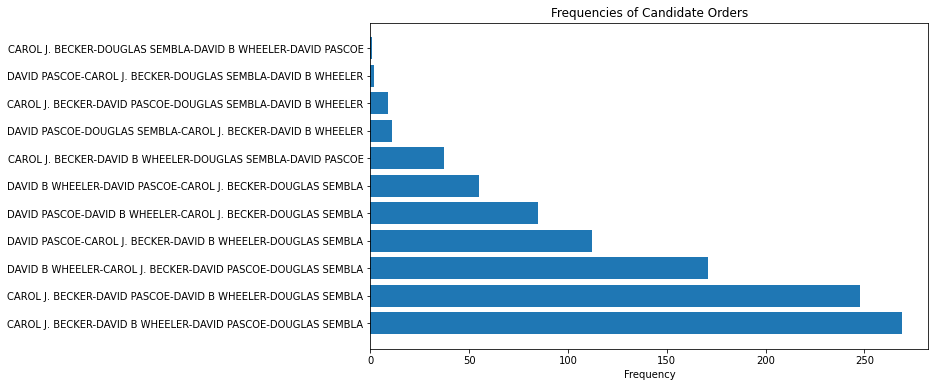

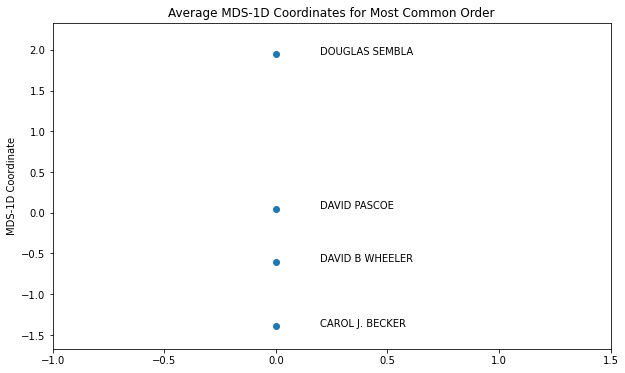

In [32]:
# Test the function with a custom CSV file
custom = perform_rcv_analysis("../rcv_elections_database/proportional/Minneapolis 2013-board of estimation and taxation cvr.csv", n_runs=1000)
mds_1d_coordinates, mds_2d_coordinates, most_common_order, order_frequencies, candidate_names = custom

# Print the normalized distances between candidates and plot the MDS analysis
print(get_distances_normalized(most_common_order, mds_1d_coordinates, candidate_names))
plot_rcv_analysis(mds_1d_coordinates, mds_2d_coordinates, most_common_order, order_frequencies, candidate_names)

/var/folders/g2/25z774tn0599smwks8_v_k200000gp/T/ipykernel_38843/1792724798.py:63: RuntimeWarning: divide by zero encountered in divide
  frequencies = counts / mentioned_together
/var/folders/g2/25z774tn0599smwks8_v_k200000gp/T/ipykernel_38843/1792724798.py:74: RuntimeWarning: divide by zero encountered in divide
  distance = 1 / np.sqrt(freq_upper_triangle)


{'Jonathan Honerbrink': 0.0, 'Bob Sullentrop': 0.00047659531516930126, 'Meg Forney': 2.982366553980931, 'Devin Hogan': 2.9838188880642265, 'Russ Henry': 2.9850387126863236, 'Mike Derus': 2.986228472387965, 'Londel French': 2.987581100966937, 'Latrisha Vetaw': 2.9878208394586205, 'Charlie Casserly': 2.989030793769531, 'Scott Vreeland': 9.0}


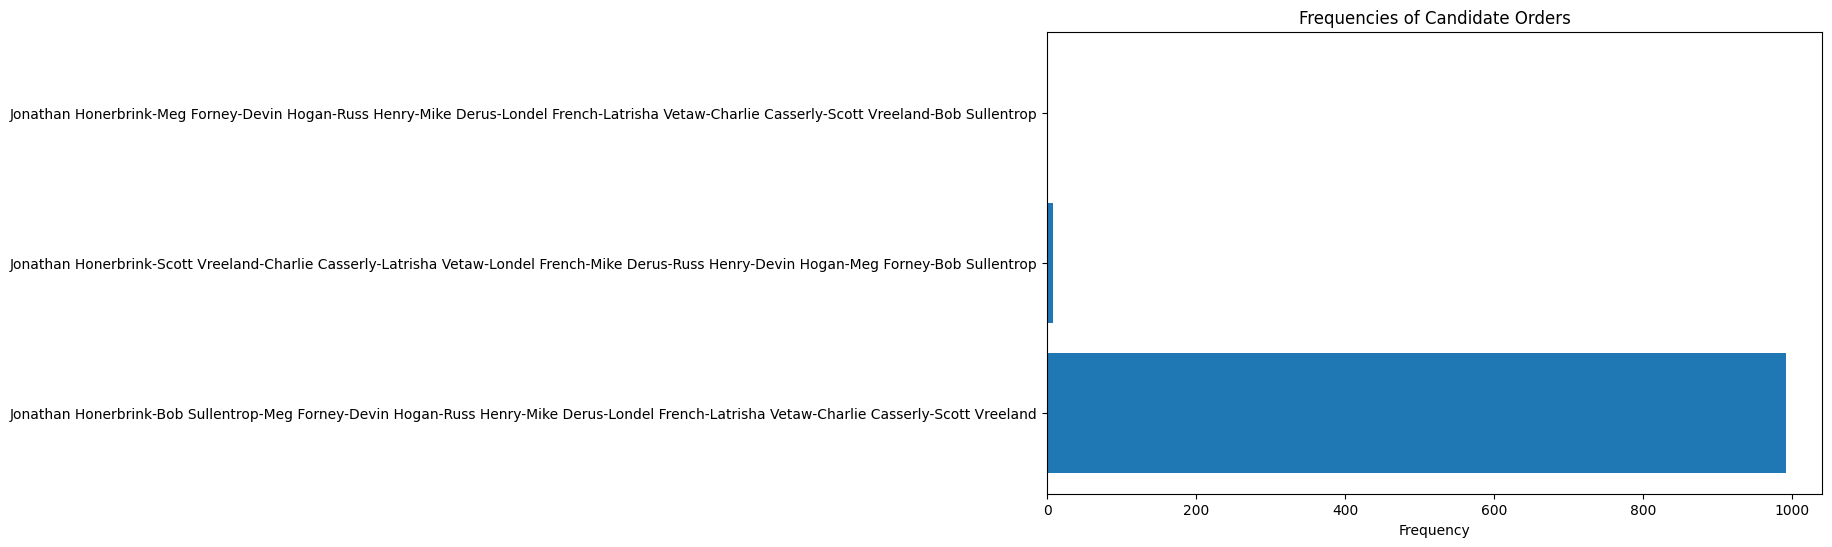

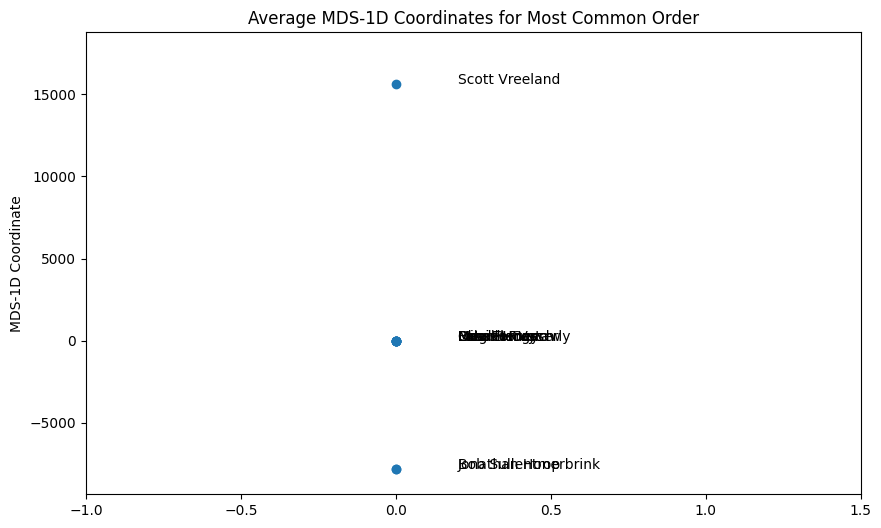

In [165]:
# Test the function with a custom CSV file
custom = perform_rcv_analysis("../rcv_elections_database/proportional/Minneapolis_11072017_ParkBoardAtLarge.csv", n_runs=1000)
mds_1d_coordinates, mds_2d_coordinates, most_common_order, order_frequencies, candidate_names = custom

# Print the normalized distances between candidates and plot the MDS analysis
print(get_distances_normalized(most_common_order, mds_1d_coordinates, candidate_names))
plot_rcv_analysis(mds_1d_coordinates, mds_2d_coordinates, most_common_order, order_frequencies, candidate_names)

C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_32760\1413760791.py:63: RuntimeWarning: divide by zero encountered in true_divide
  frequencies = counts / mentioned_together
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_32760\1413760791.py:63: RuntimeWarning: invalid value encountered in true_divide
  frequencies = counts / mentioned_together
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_32760\1413760791.py:74: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)


Stress value:  493858442.4713191
Stress value:  149139601.7142725
Stress value:  246986461.1427864
Stress value:  149139601.71488145
Stress value:  246986461.14278644
Stress value:  149139601.7255809
Stress value:  246986461.1427864
Stress value:  149139601.7269539
Stress value:  246986461.14278644
Stress value:  149139601.72109824
Stress value:  493339704.2163529
Stress value:  149139601.7388359
Stress value:  370792298.4761199
Stress value:  149139601.72671583
Stress value:  370793081.88531214
Stress value:  149139601.71836242
Stress value:  246986461.14278638
Stress value:  149139601.7320306
Stress value:  370793081.88531226
Stress value:  149139601.72775155
Stress value:  246986461.14278644
Stress value:  149139601.717182
Stress value:  370792298.47611976
Stress value:  149139601.7332904
Stress value:  370792298.4761198
Stress value:  149139601.71430233
Stress value:  370793081.88531214
Stress value:  149139601.71458384
Stress value:  246986461.14278644
Stress value:  149139601.709

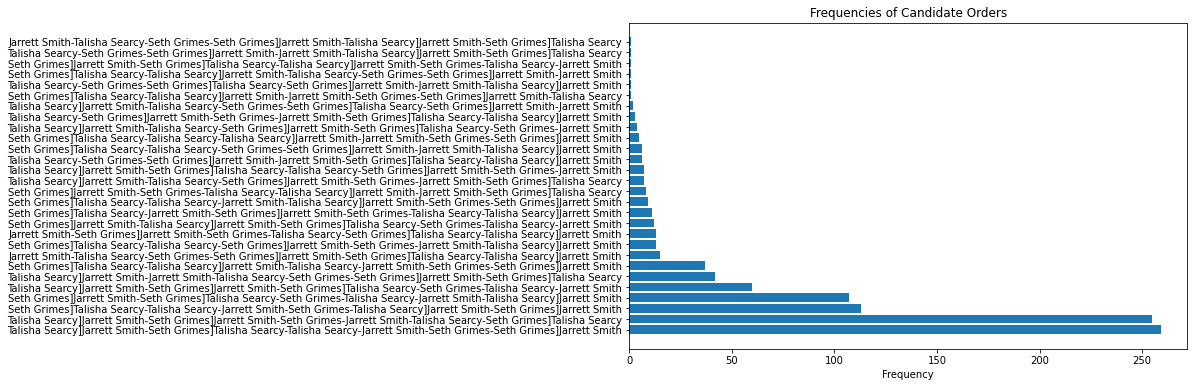

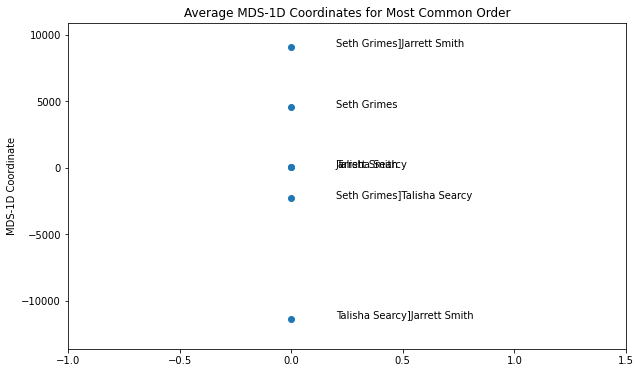

In [37]:
# Test the function with a custom CSV file
custom = perform_rcv_analysis("../rcv_elections_database/classic/TakomaPark_11082022_Mayor.csv", n_runs=1000)
mds_1d_coordinates, mds_2d_coordinates, most_common_order, order_frequencies, candidate_names = custom

# Print the normalized distances between candidates and plot the MDS analysis
print(get_distances_normalized(most_common_order, mds_1d_coordinates, candidate_names))
plot_rcv_analysis(mds_1d_coordinates, mds_2d_coordinates, most_common_order, order_frequencies, candidate_names)

C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_32760\1413760791.py:74: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)


Stress value:  0.8512870005829388
Stress value:  0.11348043285025788
Stress value:  5.329758628464653
Stress value:  0.13445081787218538
Stress value:  2.3964120129778173
Stress value:  0.13688508551781617
Stress value:  2.396412012977817
Stress value:  0.1141129866128695
Stress value:  4.865221499026912
Stress value:  0.11628275984095594
Stress value:  2.9858583171889075
Stress value:  0.11234277073020937
Stress value:  0.851287000582939
Stress value:  0.3009680321856353
Stress value:  0.851287000582939
Stress value:  0.1165260629935671
Stress value:  5.204973691366053
Stress value:  0.11221581162272841
Stress value:  4.865221499026912
Stress value:  0.11242216815735091
Stress value:  2.3964120129778177
Stress value:  0.11417164058551575
Stress value:  4.865221499026912
Stress value:  0.11337998299005131
Stress value:  5.635327366825724
Stress value:  0.11444320943320442
Stress value:  7.464329945070622
Stress value:  0.133620129847115
Stress value:  0.8512870005829389
Stress value:  

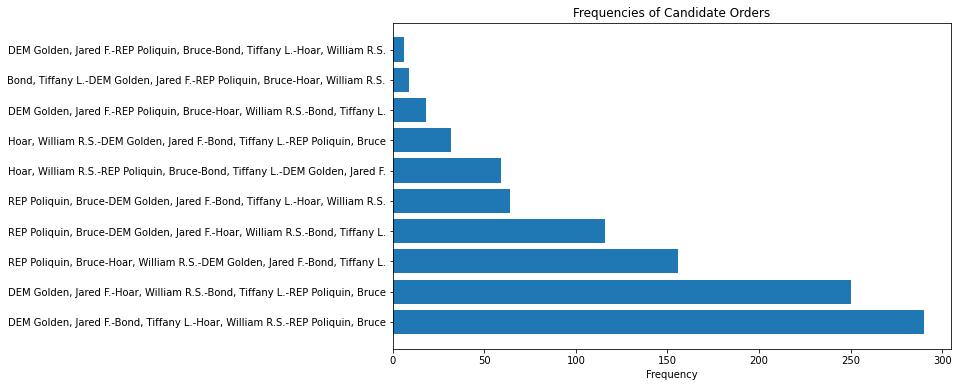

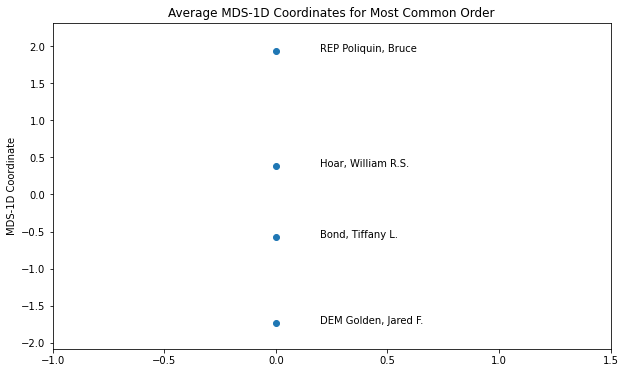

In [33]:
# Test the function with the provided CSV file
maine = perform_rcv_analysis("../rcv_elections_database/classic/Maine_11062018_CongressionalDistrict2.csv", n_runs=1000)
mds_1d_coordinates, mds_2d_coordinates, most_common_order, order_frequencies, candidate_names = maine

# Print the normalized distances between candidates and plot the MDS analysis
print(get_distances_normalized(most_common_order, mds_1d_coordinates, candidate_names))
plot_rcv_analysis(mds_1d_coordinates, mds_2d_coordinates, most_common_order, order_frequencies, candidate_names)

C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_32760\1413760791.py:74: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)


Stress value:  4.589216622769046
Stress value:  0.11969433611853712
Stress value:  2.6611199606171887
Stress value:  0.11981456485447917
Stress value:  1.7636535803130688
Stress value:  0.11962061016860524
Stress value:  2.6611199606171896
Stress value:  0.12060192849895877
Stress value:  3.902837049100042
Stress value:  0.11904655437528137
Stress value:  4.429559033076653
Stress value:  0.11984274612844667
Stress value:  3.9028370491000426
Stress value:  0.11924218973529026
Stress value:  1.763653580313069
Stress value:  0.11962170048965631
Stress value:  1.7636535803130686
Stress value:  0.11952747726680116
Stress value:  1.7636535803130688
Stress value:  0.11945351238129139
Stress value:  2.6611199606171896
Stress value:  0.11969649666494983
Stress value:  4.429559033076654
Stress value:  0.12007069989252057
Stress value:  2.6611199606171896
Stress value:  0.1191743399693394
Stress value:  3.902837049100043
Stress value:  0.11994343205272655
Stress value:  6.052670466122547
Stress v

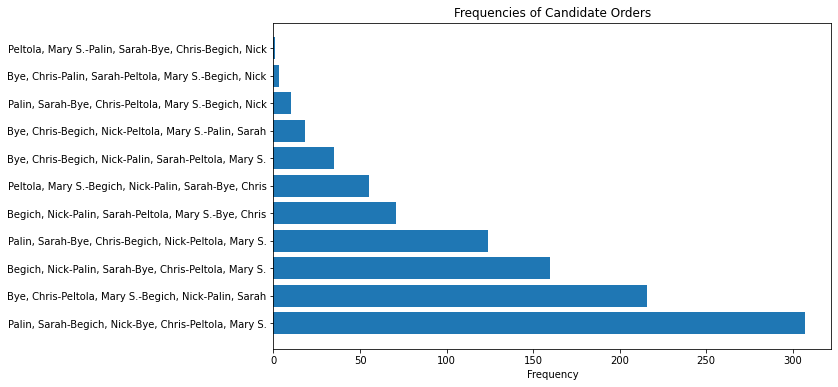

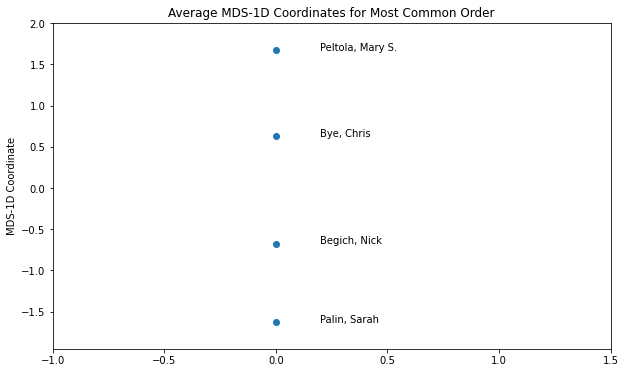

In [35]:
# Test the function with the provided CSV file
alaska = perform_rcv_analysis("../rcv_elections_database/classic/Alaska_11082022_USRepresentative.csv", n_runs=1000)
mds_1d_coordinates, mds_2d_coordinates, most_common_order, order_frequencies, candidate_names = alaska

# Print the normalized distances between candidates and plot the MDS analysis
print(get_distances_normalized(most_common_order, mds_1d_coordinates, candidate_names))
plot_rcv_analysis(mds_1d_coordinates, mds_2d_coordinates, most_common_order, order_frequencies, candidate_names)

C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_32760\1413760791.py:74: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)


Stress value:  58.76007275469
Stress value:  12.287865815514733
Stress value:  59.28706735089757
Stress value:  12.824484387969365
Stress value:  22.421399265446688
Stress value:  12.278419622330407
Stress value:  26.895066118310517
Stress value:  12.268363351687054
Stress value:  23.611427456186505
Stress value:  12.271831606838834
Stress value:  23.44877173102875
Stress value:  12.314306422183492
Stress value:  26.793174544762042
Stress value:  12.308786133790187
Stress value:  79.78351114117935
Stress value:  12.281353078418304
Stress value:  62.89124984896372
Stress value:  12.303529608971115
Stress value:  23.931875832328153
Stress value:  12.264300083898155
Stress value:  49.35380863727431
Stress value:  12.290903962484075
Stress value:  23.022154374988826
Stress value:  12.302899449549031
Stress value:  21.73796824614665
Stress value:  12.28564101077367
Stress value:  22.56247066784904
Stress value:  12.296580568742115
Stress value:  28.17264965161865
Stress value:  12.292024444

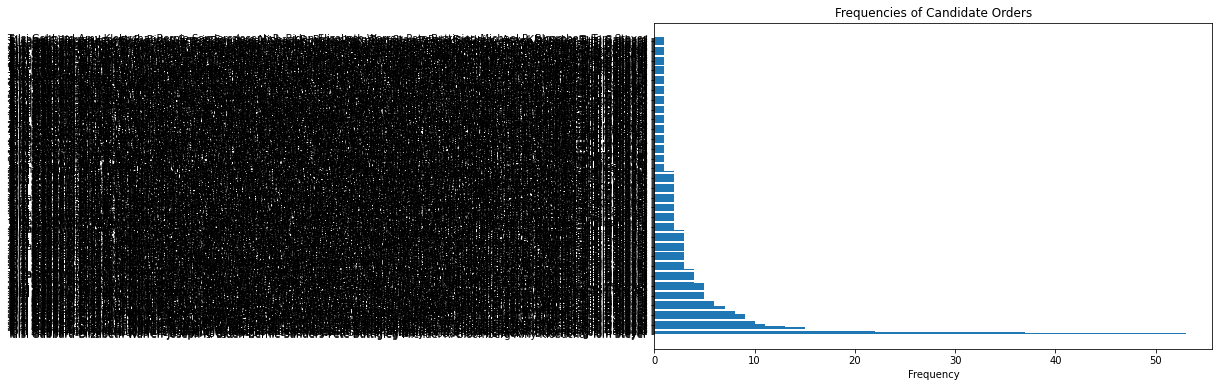

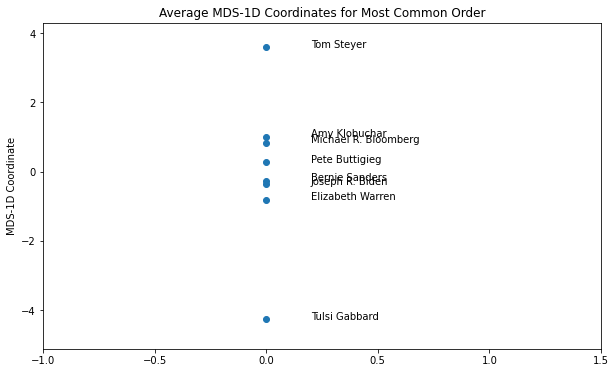

In [36]:
# Test the function with the provided CSV file
president = perform_rcv_analysis("../rcv_elections_database/classic/Alaska_04102020_PRESIDENTOFTHEUNITEDSTATES.csv", n_runs=1000)
mds_1d_coordinates, mds_2d_coordinates, most_common_order, order_frequencies, candidate_names = president

# Print the normalized distances between candidates and plot the MDS analysis
print(get_distances_normalized(most_common_order, mds_1d_coordinates, candidate_names))
plot_rcv_analysis(mds_1d_coordinates, mds_2d_coordinates, most_common_order, order_frequencies, candidate_names)

/var/folders/g2/25z774tn0599smwks8_v_k200000gp/T/ipykernel_38843/3474638718.py:73: RuntimeWarning: divide by zero encountered in divide
  distance = 1 / np.sqrt(freq_upper_triangle)


{'Guillermo A. Perez': 0.0, 'Lindsey C. Boylan': 2.542501628327277, 'Kimberly R. Watkins': 2.6256604469159113, 'Mark D. Levine': 4.025458295461505, 'Brad M. Hoylman': 4.63201316980782, 'Ben Kallos': 5.018591589080432, 'Elizabeth R. Caputo': 6.0}


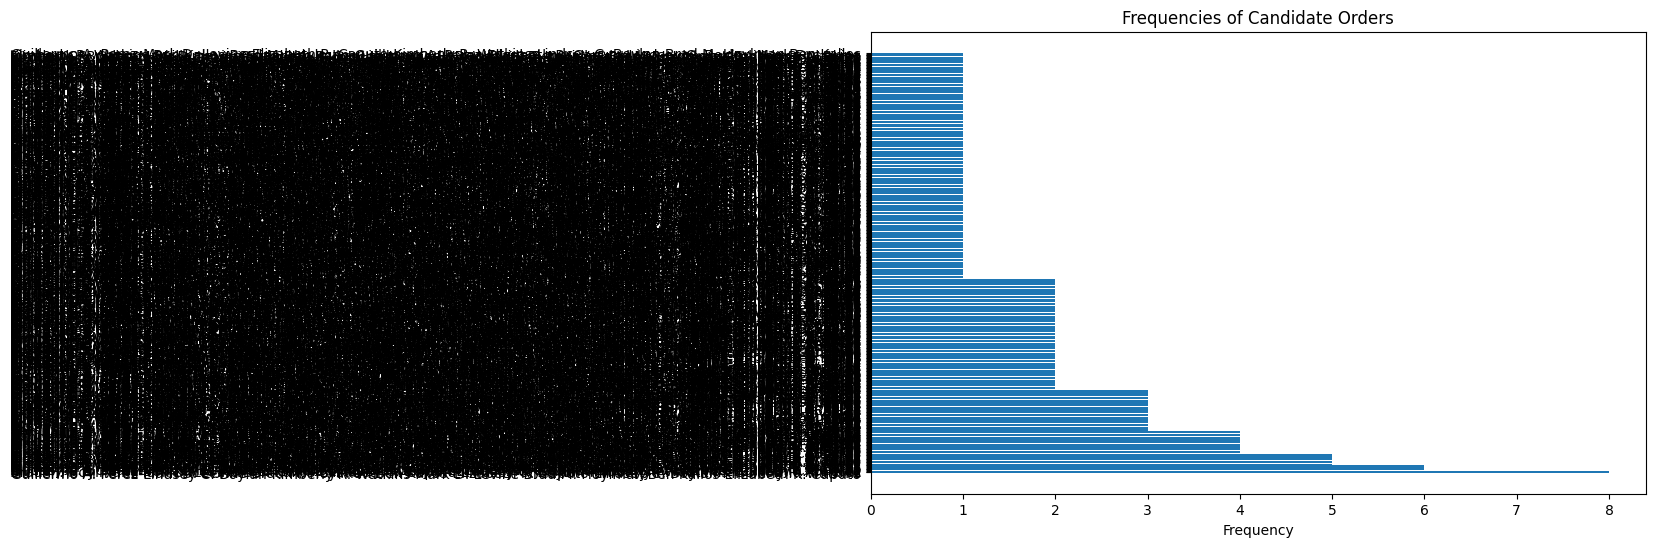

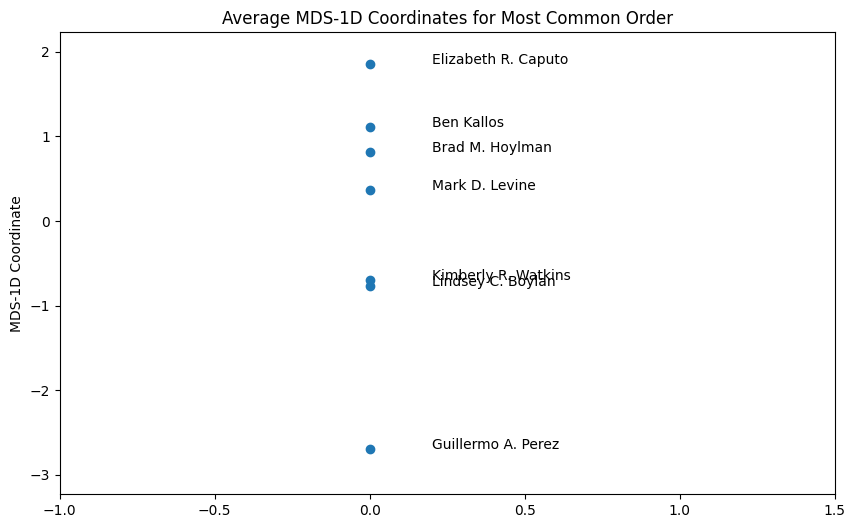

In [66]:
# Test the function with the provided CSV file
nyc = perform_rcv_analysis("../rcv_elections_database/classic/NewYorkCity_06222021_DEMBoroughPresidentNewYork.csv", n_runs=1000)
mds_1d_coordinates, mds_2d_coordinates, most_common_order, order_frequencies, candidate_names = nyc

# Print the normalized distances between candidates and plot the MDS analysis
print(get_distances_normalized(most_common_order, mds_1d_coordinates, candidate_names))
plot_rcv_analysis(mds_1d_coordinates, mds_2d_coordinates, most_common_order, order_frequencies, candidate_names)

/var/folders/g2/25z774tn0599smwks8_v_k200000gp/T/ipykernel_38843/3474638718.py:62: RuntimeWarning: divide by zero encountered in divide
  frequencies = counts / mentioned_together
/var/folders/g2/25z774tn0599smwks8_v_k200000gp/T/ipykernel_38843/3474638718.py:73: RuntimeWarning: divide by zero encountered in divide
  distance = 1 / np.sqrt(freq_upper_triangle)


{'EDMUND BERNARD BRUYERE': 0.0, 'JAMES "JIMMY" L. STROUD, JR.': 8.497523465652685, 'MERRILL ANDERSON': 8.509099511801752, 'MIKE GOULD': 16.910880344060526, 'BOB FINE': 16.97183520983149, 'JOSHUA REA': 16.984134647534432, 'BILL KAHN': 16.997638335624465, 'STEPHANIE WOODRUFF': 16.999183228847347, 'ALICIA K. BENNETT': 17.001391926607223, 'DON SAMUELS': 17.00309860757442, 'GREGG A. IVERSON': 17.00427955813214, 'DAN COHEN': 17.005631101251655, 'BETSY HODGES': 17.006816939012573, 'ABDUL M RAHAMAN "THE ROCK"': 17.00724278586809, 'JACKIE CHERRYHOMES': 17.008621440125417, 'TROY BENJEGERDES': 17.010083038414376, 'TONY LANE': 17.011452414575153, 'CAPTAIN JACK SPARROW': 17.011458051917586, 'MARK ANDREW': 17.012057634130112, 'MARK V ANDERSON': 17.012190687606058, 'CAM WINTON': 17.01303597892706, 'CYD GORMAN': 17.01530015316277, 'KURTIS W. HANNA': 17.01735638938029, 'JOHN CHARLES WILSON': 17.01947022412282, 'JAYMIE KELLY': 17.021295408989193, 'DOUG MANN': 17.02325438035869, 'CHRISTOPHER CLARK': 17.0

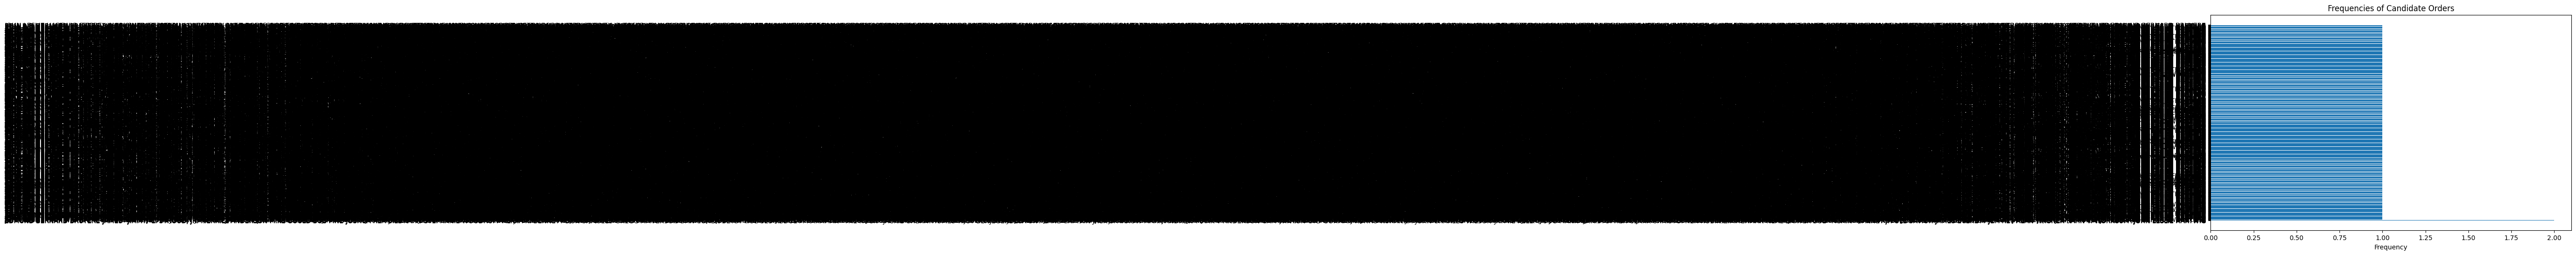

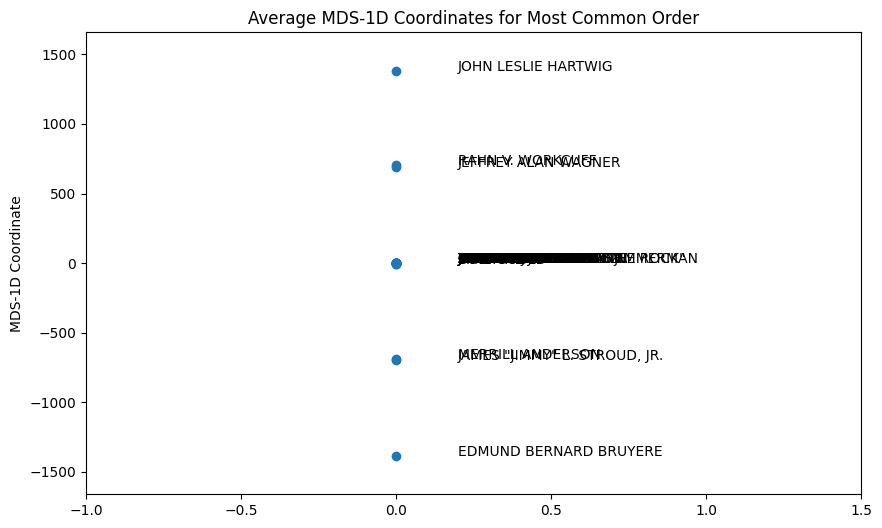

In [67]:
# Test the function with the provided CSV file
minneapolis = perform_rcv_analysis("../rcv_elections_database/classic/Minneapolis_11052013_Mayor.csv", n_runs=1000)
mds_1d_coordinates, mds_2d_coordinates, most_common_order, order_frequencies, candidate_names = minneapolis

# Print the normalized distances between candidates and plot the MDS analysis
print(get_distances_normalized(most_common_order, mds_1d_coordinates, candidate_names))
plot_rcv_analysis(mds_1d_coordinates, mds_2d_coordinates, most_common_order, order_frequencies, candidate_names)

/var/folders/g2/25z774tn0599smwks8_v_k200000gp/T/ipykernel_38843/3474638718.py:73: RuntimeWarning: divide by zero encountered in divide
  distance = 1 / np.sqrt(freq_upper_triangle)


{'Grant, Benjamin K.': 0.0, 'Lentz, Sarah M.': 0.5849984350663897, 'Albert, Stephanie G.': 1.5113015777483305, 'Schertz, Amber J.': 3.366909486571453, 'Hang, Stacey L.': 4.148097782065832, 'Ward, Richard L.': 5.408653739365983, 'Mancini, Kimberly A.': 6.0}


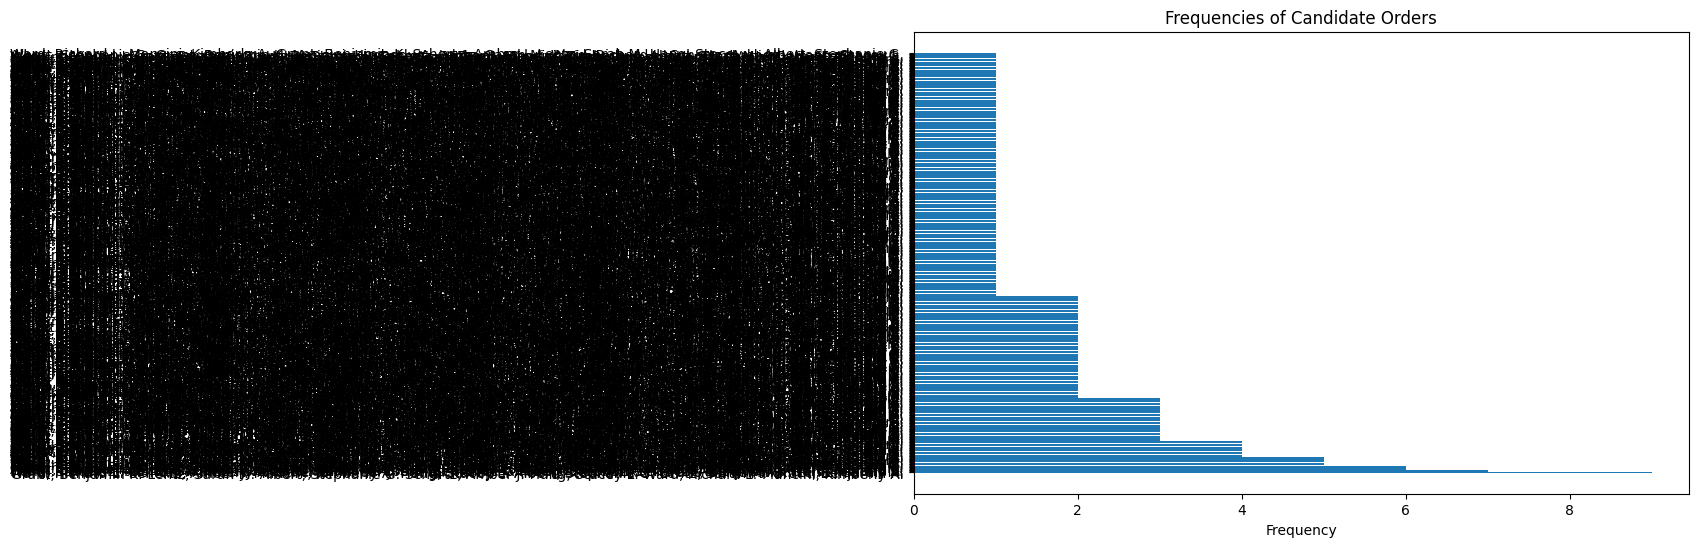

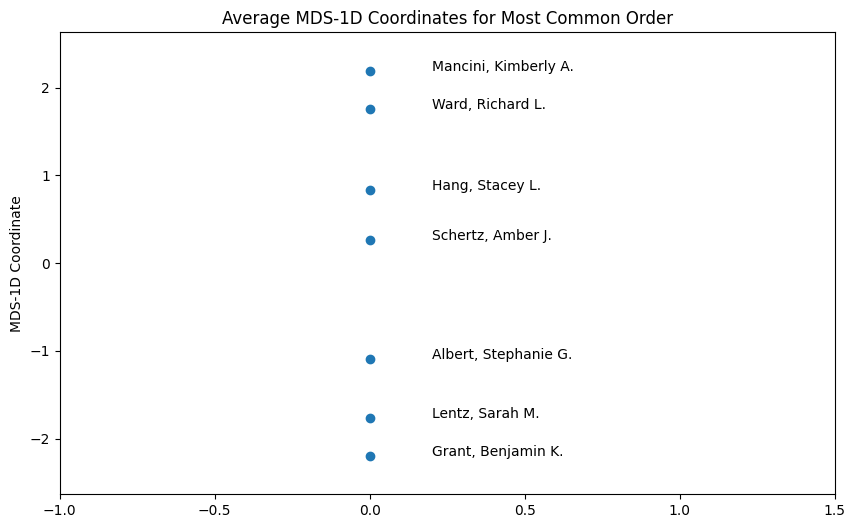

In [70]:
# Test the function with the provided CSV file
portland = perform_rcv_analysis("../rcv_elections_database/classic/Portland_06142022_SchoolboardAL-1.csv", n_runs=1000)
mds_1d_coordinates, mds_2d_coordinates, most_common_order, order_frequencies, candidate_names = portland

# Print the normalized distances between candidates and plot the MDS analysis
print(get_distances_normalized(most_common_order, mds_1d_coordinates, candidate_names))
plot_rcv_analysis(mds_1d_coordinates, mds_2d_coordinates, most_common_order, order_frequencies, candidate_names)

In [72]:
# Test the function with the provided CSV file
easthampton = perform_rcv_analysis("../rcv_elections_database/classic/Easthampton_11022021_Mayor.csv", n_runs=1000)
mds_1d_coordinates, mds_2d_coordinates, most_common_order, order_frequencies, candidate_names = easthampton

# Print the normalized distances between candidates and plot the MDS analysis
print(get_distances_normalized(most_common_order, mds_1d_coordinates, candidate_names))
plot_rcv_analysis(mds_1d_coordinates, mds_2d_coordinates, most_common_order, order_frequencies, candidate_names)

ValueError: zero-size array to reduction operation minimum which has no identity

In [74]:
# Test the function with the provided CSV file
easthampton = perform_rcv_analysis("../rcv_elections_database/classic/Easthampton_11022021_Mayor.csv", n_runs=1000)
mds_1d_coordinates, mds_2d_coordinates, most_common_order, order_frequencies, candidate_names = easthampton

# Print the normalized distances between candidates and plot the MDS analysis
print(get_distances_normalized(most_common_order, mds_1d_coordinates, candidate_names))
plot_rcv_analysis(mds_1d_coordinates, mds_2d_coordinates, most_common_order, order_frequencies, candidate_names)

/var/folders/g2/25z774tn0599smwks8_v_k200000gp/T/ipykernel_38843/3474638718.py:62: RuntimeWarning: divide by zero encountered in divide
  frequencies = counts / mentioned_together
/var/folders/g2/25z774tn0599smwks8_v_k200000gp/T/ipykernel_38843/3474638718.py:62: RuntimeWarning: invalid value encountered in divide
  frequencies = counts / mentioned_together
/var/folders/g2/25z774tn0599smwks8_v_k200000gp/T/ipykernel_38843/3474638718.py:73: RuntimeWarning: divide by zero encountered in divide
  distance = 1 / np.sqrt(freq_upper_triangle)


KeyboardInterrupt: 

In [3]:
""" # RIP
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from numba import njit

from sklearn.manifold import MDS
from scipy.spatial import distance_matrix
from sklearn.preprocessing import LabelEncoder


@njit
def calculate_mentioned_together(ballots, num_candidates, num_ballots, num_ranks):
    mentioned_together = np.zeros((num_candidates, num_candidates))
    for i in range(num_ballots):
        for j in range(num_ranks):
            for k in range(num_ranks):
                if ballots[i, j] <= num_candidates and ballots[i, k] <= num_candidates:
                    mentioned_together[ballots[i, j]-1, ballots[i, k]-1] += 1
    return mentioned_together


def perform_rcv_analysis(csv_file, ignore_values=None, metric=False):
    if ignore_values is None:
        ignore_values = ['(WRITE-IN)', 'writein', 'Write-In', 'Write-in', 'skipped', 'overvote']

    # Load the CSV file
    df = pd.read_csv(csv_file)
    
    # Keep only the 'rank' columns
    df = df.filter(regex='^rank')

    # Filter out rows that contain non-candidate values
    df = df[~df.isin(ignore_values)].dropna()
    
    # Convert the DataFrame to a 2D list
    raw_ballots = df.values.tolist()

    # Create a list of all candidate names
    candidate_names = pd.unique(df.values.ravel())
    
    # Convert names to integer codes
    candidate_dict = {name: i for i, name in enumerate(candidate_names)}
    ballots = [[candidate_dict[candidate] for candidate in ballot] for ballot in raw_ballots]
    num_candidates = len(candidate_names)

    # Convert ballots to a NumPy array
    ballots = np.array(ballots)

    # Get the number of ballots and ranks
    num_ballots, num_ranks = ballots.shape

    # Count up frequencies of consecutive-pair ballot choices
    counts = np.zeros((num_candidates, num_candidates))
    for i in range(num_ballots):
        for j in range(num_ranks - 1):
            counts[ballots[i, j], ballots[i, j+1]] += 1

    # Calculate 'mentioned_together'
    mentioned_together = calculate_mentioned_together(ballots, num_candidates, num_ballots, num_ranks)

    # Normalize to frequencies relative to votes cast for the two candidates
    frequencies = counts / mentioned_together

    # Combine frequencies in either direction to create symmetric matrix
    freq_upper_triangle = np.zeros((num_candidates, num_candidates))
    for i in range(num_candidates):
        for j in range(i+1, num_candidates):
            freq_upper_triangle[i, j] = (frequencies[i, j] + frequencies[j, i]) / 2
            freq_upper_triangle[j, i] = freq_upper_triangle[i, j]

    # Compute 'd' (distance metric)
    min_freq = np.min(freq_upper_triangle[freq_upper_triangle > 0])
    distance = 1 / np.sqrt(freq_upper_triangle)
    distance[np.isnan(distance)] = 2 / min_freq
    distance[np.isinf(distance)] = 2 / min_freq
    np.fill_diagonal(distance, 0)

    # Perform nonmetric MDS for 1 dimension
    mds = MDS(n_components=1, metric=metric, max_iter=1000, dissimilarity='precomputed')
    y_values_1d = mds.fit_transform(distance)

    # Identify common order in 1D
    order_1d = np.argsort(y_values_1d.flatten())

    # Calculate pairwise distances in 1D
    pairwise_distances_1d = distance_matrix(y_values_1d, y_values_1d)

    # Store distances and order in dictionary
    distance_dict = {}
    distance_dict["1D"] = {}
    distance_dict["1D"]["order"] = candidate_names[order_1d]
    distance_dict["1D"]["distances"] = pairwise_distances_1d

    # Plot 1D
    plt.figure(figsize=(10, 6))
    plt.scatter(np.zeros_like(y_values_1d), y_values_1d)
    for i in range(num_candidates):
        plt.text(0.2, y_values_1d[i], candidate_names[i])
    plt.axis([-1, 1.5, y_values_1d.min()*1.2, y_values_1d.max()*1.2])
    plt.show()

    # Perform nonmetric MDS for 2 dimensions
    mds = MDS(n_components=2, metric=metric, max_iter=1000, dissimilarity='precomputed')
    y_values_2d = mds.fit_transform(distance)

    # Identify common order in 2D
    order_2d = np.lexsort(y_values_2d.T)

    # Calculate pairwise distances in 2D
    pairwise_distances_2d = distance_matrix(y_values_2d, y_values_2d)

    # Store distances and order in dictionary
    distance_dict["2D"] = {}
    distance_dict["2D"]["order"] = candidate_names[order_2d]
    distance_dict["2D"]["distances"] = pairwise_distances_2d

    # Plot 2D
    plt.figure(figsize=(10, 6))
    plt.scatter(y_values_2d[:, 0], y_values_2d[:, 1])
    for i in range(num_candidates):
        plt.text(y_values_2d[i, 0], y_values_2d[i, 1], candidate_names[i])
    plt.grid(True)
    plt.show()

    return distance_dict
""" # CODE GRAVEYARD

' # RIP\nimport numpy as np\nimport pandas as pd\n\nimport matplotlib.pyplot as plt\n\nfrom numba import njit\n\nfrom sklearn.manifold import MDS\nfrom scipy.spatial import distance_matrix\nfrom sklearn.preprocessing import LabelEncoder\n\n\n@njit\ndef calculate_mentioned_together(ballots, num_candidates, num_ballots, num_ranks):\n    mentioned_together = np.zeros((num_candidates, num_candidates))\n    for i in range(num_ballots):\n        for j in range(num_ranks):\n            for k in range(num_ranks):\n                if ballots[i, j] <= num_candidates and ballots[i, k] <= num_candidates:\n                    mentioned_together[ballots[i, j]-1, ballots[i, k]-1] += 1\n    return mentioned_together\n\n\ndef perform_rcv_analysis(csv_file, ignore_values=None, metric=False):\n    if ignore_values is None:\n        ignore_values = [\'(WRITE-IN)\', \'writein\', \'Write-In\', \'Write-in\', \'skipped\', \'overvote\']\n\n    # Load the CSV file\n    df = pd.read_csv(csv_file)\n    \n    # Ke

In [20]:
""" # RIP
import umap
from sklearn.preprocessing import OneHotEncoder

# Load the CSV file
df = pd.read_csv(f"Alaska_11082022_USRepresentative.csv")

# Filter out rows that do not have a candidate ranked first
ignore_values = ['skipped', 'overvote', 'writein','Write-in']
df = df[~df['rank1'].isin(ignore_values)]

# Create a list of all candidate names
candidate_names = pd.unique(df['rank1'])

# Perform one-hot encoding
encoder = OneHotEncoder(sparse=False, categories=[candidate_names])
ballots = encoder.fit_transform(df[['rank1']])

# Perform UMAP embedding
embedding = umap.UMAP().fit_transform(ballots)

# Plot the voting clusters
plt.scatter(embedding[:, 0], embedding[:, 1], s=1)

# Calculate and plot the mean position of each candidate
for i, candidate in enumerate(candidate_names):
    mean_position = embedding[df['rank1'] == candidate].mean(axis=0)
    plt.scatter(mean_position[0], mean_position[1])
    plt.text(mean_position[0], mean_position[1], candidate)

plt.show()
""" # CODE GRAVEYARD

' # RIP\nimport umap\nfrom sklearn.preprocessing import OneHotEncoder\n\n# Load the CSV file\ndf = pd.read_csv(f"Alaska_11082022_USRepresentative.csv")\n\n# Filter out rows that do not have a candidate ranked first\nignore_values = [\'skipped\', \'overvote\', \'writein\',\'Write-in\']\ndf = df[~df[\'rank1\'].isin(ignore_values)]\n\n# Create a list of all candidate names\ncandidate_names = pd.unique(df[\'rank1\'])\n\n# Perform one-hot encoding\nencoder = OneHotEncoder(sparse=False, categories=[candidate_names])\nballots = encoder.fit_transform(df[[\'rank1\']])\n\n# Perform UMAP embedding\nembedding = umap.UMAP().fit_transform(ballots)\n\n# Plot the voting clusters\nplt.scatter(embedding[:, 0], embedding[:, 1], s=1)\n\n# Calculate and plot the mean position of each candidate\nfor i, candidate in enumerate(candidate_names):\n    mean_position = embedding[df[\'rank1\'] == candidate].mean(axis=0)\n    plt.scatter(mean_position[0], mean_position[1])\n    plt.text(mean_position[0], mean_posit

In [19]:
""" # RIP
from pyirt import irt

# Reshape your data to long format
# Each row should be a voter-candidate pair, with the voter ID, the candidate ID, and the rank
data_long = df.melt(id_vars='voter_id', var_name='candidate_id', value_name='rank')

# Fit the IRT model
item_param, user_param = irt(data_long['voter_id'], data_long['candidate_id'], data_long['rank'])

# Plot the estimated parameters
plt.scatter(user_param, [1]*len(user_param), label='Voters')
plt.scatter(item_param, [1]*len(item_param), label='Candidates')
plt.legend()
plt.show()
""" # CODE GRAVEYARD

" # RIP\nfrom pyirt import irt\n\n# Reshape your data to long format\n# Each row should be a voter-candidate pair, with the voter ID, the candidate ID, and the rank\ndata_long = df.melt(id_vars='voter_id', var_name='candidate_id', value_name='rank')\n\n# Fit the IRT model\nitem_param, user_param = irt(data_long['voter_id'], data_long['candidate_id'], data_long['rank'])\n\n# Plot the estimated parameters\nplt.scatter(user_param, [1]*len(user_param), label='Voters')\nplt.scatter(item_param, [1]*len(item_param), label='Candidates')\nplt.legend()\nplt.show()\n"